<a href="https://colab.research.google.com/github/shruttiguptta/Exploratory-data-Ananlysis/blob/main/YoutubeData_ExploratoryDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
import json
import pickle
import six
sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [7]:
# csv = 'sample_data/california_housing_test.csv'
csv = 'CAvideos.csv'
df = pd.read_csv(csv)

In [ ]:
df.describe()
df.columns
df.shape
df['country'] = csv[:2]
# df.head()



**START BY CLEANING THE DATA**

In [23]:
# Fix data types
df['video_id'] = df['video_id'].astype('str')
df['trending_date'] = df['trending_date'].astype('str')

In [ ]:
# Since date looks like 17.14.11 -> extract date, month, year accordingly. split('.') -> list [17,14,11]
date_pieces = (df['trending_date']
                   .str.split('.')
                  )
date_pieces.iloc[:5]

In [48]:
df['Year'] = date_pieces.str[0].astype(int)
df['Day'] = date_pieces.str[1].astype(int)
df['Month'] = date_pieces.str[2].astype(int)
updatedyear = []
for i in range(len(df)) : 
  y = df.loc[i, "Year"]
  newy = y+2000 #17->2017
  updatedyear.append(newy) #add to list
  
for i in range(len(df)):
  newy = updatedyear[i]
  tr = df.loc[i, "Year"]
  df['Year'].replace(to_replace = tr, value = newy, inplace=True)

In [52]:
# replace date with proper date format
if 'trending_date' in df.columns : 
  del df['trending_date']
df['trending_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format = "%Y-%m-%d")
if 'Year' and 'Day' and  'Month' in df.columns : 
  del df['Year']
  del df['Day']
  del df['Month']

In [61]:
df['title'] = df['title'].astype('str')
df['channel_title'] = df['channel_title'].astype('str')
df['category_id'] = df['category_id'].astype('str') 
df['tags'] = df['tags'].astype('str')
# views, likes, dislikes, comment_count are already in correct data types i.e int64
df['thumbnail_link'] = df['thumbnail_link'].astype('str')
df['description'] = df['description'].astype('str')

# Changing comments_disabled, ratings_disabled, video_error_or_removed from bool to categorical
df['comments_disabled'] = df['comments_disabled'].astype('category') 
df['ratings_disabled'] = df['ratings_disabled'].astype('category') 
df['video_error_or_removed'] = df['video_error_or_removed'].astype('category') 
    
# publish_time 
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce', format='%Y-%m-%dT%H:%M:%S.%fZ')

df['publish_time'].iloc[:5]

0   2017-11-10 17:00:03
1   2017-11-13 17:00:00
2   2017-11-12 19:05:24
3   2017-11-12 18:01:41
4   2017-11-09 11:04:14
Name: publish_time, dtype: datetime64[ns]

Separating ‘publish_time’ into ‘publish_date’ and ‘publish_time’

In [62]:

df.insert(4, 'publish_date', df['publish_time'].dt.date) # loc, column name, values for column to be inserted
df['publish_time'] = df['publish_time'].dt.time

# Changing data type for 'publish_date' from object to 'datetime64[ns]'

df['publish_date'] = pd.to_datetime(df['publish_date'], format = "%Y-%m-%d")

In [ ]:
df.dtypes

In [64]:
df.set_index('video_id', inplace=True)

In [ ]:
sns.heatmap(df.isnull(), cbar=False)
plt.figure()

In [ ]:
# Making copy of original dataframe
backup_df = df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')
combined_df = df
# Sorting according to latest trending date while removing duplicates
combined_df = combined_df.reset_index().sort_values('trending_date', ascending=False).drop_duplicates('video_id',keep='first').set_index('video_id')
combined_df[['publish_date','publish_time','trending_date', 'country']].head()


Inserting Category Column --- From Json file

In [ ]:
with open('CA_category_id.json', 'r') as f:  # reading one randomly selected json files to make sense of its contents
    data = f.read()
# parse file
obj = json.loads(data)
# printing
obj

In [ ]:
category_id = {}
with open('CA_category_id.json', 'r') as f:
    d = json.load(f)
    for category in d['items']:
        category_id[category['id']] = category['snippet']['title']
combined_df.insert(2, 'category', combined_df['category_id'].map(category_id))
backup_df.insert(2, 'category', backup_df['category_id'].map(category_id))

df.insert(2, 'category', df['category_id'].map(category_id))
# Printing cleaned combined dataframe
combined_df.head(3)

In [71]:
combined_df.head(1)

,title,channel_title,category,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
video_id,,,,,,,,,,,,,,,,,,
POTgw38-m58,【完整版】遇到恐怖情人該怎麼辦？2018.06.13小明星大跟班,我愛小明星大跟班,Entertainment,24,2018-06-13,16:00:03,"吳宗憲|""吳姍儒""|""小明星大跟班""|""Sandy""|""Jacky wu""|""憲哥""|""中天...",107392,300,62,251,https://i.ytimg.com/vi/POTgw38-m58/default.jpg,False,False,False,藝人：李妍瑾、玉兔、班傑、LaLa、小優、少少專家：陳筱屏(律師)、Wendy(心理師)、羅...,CA,2018-06-14


In [72]:
combined_df['category'].unique()

array(['Entertainment', 'News & Politics', 'Film & Animation',
       'Howto & Style', 'Music', 'Travel & Events', 'People & Blogs',
       'Shows', 'Comedy', 'Gaming', 'Sports', 'Science & Technology',
       'Education', 'Pets & Animals', 'Autos & Vehicles', 'Movies', nan],
      dtype=object)

**DATA Cleaning is now over, we start with EDA(Exploratory Data Analysis)**

Q1: Ratio of likes-dislikes in different categories

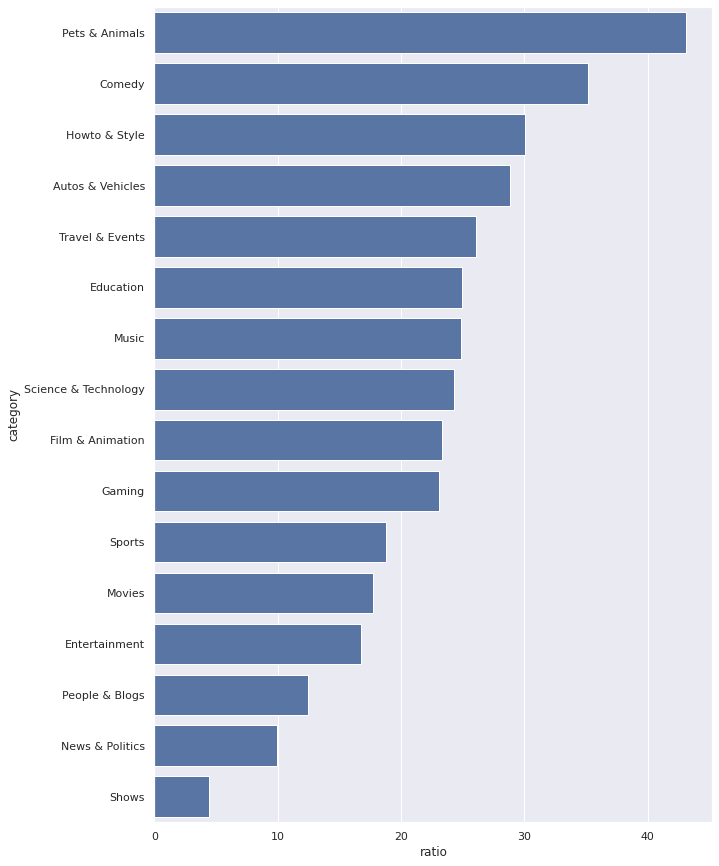

In [73]:
# calculating total likes for each category
likesdf = combined_df.groupby('category')['likes'].agg('sum')
# calculating total dislikes for each category
dislikesdf = combined_df.groupby('category')['dislikes'].agg('sum')
# calculating ratios of likes to dislikes
ratiodf = likesdf/dislikesdf 
# most liked category to appear on top
ratiodf = ratiodf.sort_values(ascending=False).reset_index()
# plotting bar chart
ratiodf.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=ratiodf,
            label="Likes-Dislikes Ratio", color="b")

Q2 : Which category has most videos?

<Figure size 432x288 with 0 Axes>

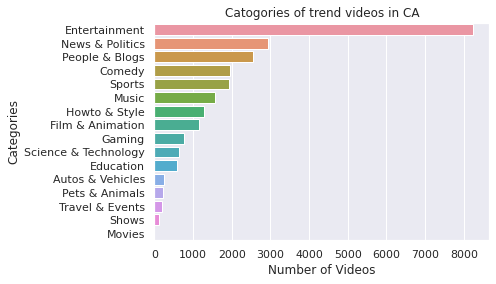

<Figure size 432x288 with 0 Axes>

In [75]:
tempdf = combined_df['category'].value_counts().reset_index() 
ax = sns.barplot(y=tempdf['index'], x=tempdf['category'], data=tempdf, orient='h')
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in " + country)
plt.figure()

Q3 : Users like videos from which category more?

<Figure size 432x288 with 0 Axes>

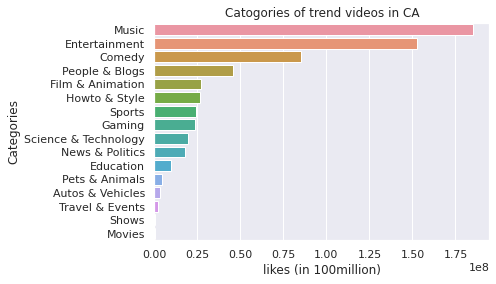

<Figure size 432x288 with 0 Axes>

In [109]:
tempdf = combined_df.groupby('category')['likes'].agg('sum').reset_index().sort_values('likes', ascending=False).reset_index()
ax = sns.barplot(y=tempdf['category'], x=tempdf['likes'], data=tempdf, orient='h')
plt.xlabel("likes (in 100million)")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in " + country)
plt.figure()

Q4: Top 5 videos that are on trending

In [120]:
temp = combined_df
temp = temp.reset_index().sort_values(by = ['views'], ascending=False)
temp.drop_duplicates(subset ="video_id", keep = 'first', inplace = True)
temp.set_index('video_id', inplace=True)
temp = temp.head(5) # top 5 that are on trending

temp[['title','category']]

,title,category
video_id,,
FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,Entertainment
VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,Music
6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Entertainment
7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,Music
_I_D_8Z4sJE,Nicky Jam x J. Balvin - X (EQUIS) | Video Ofic...,Music


Q5: Is the most liked video also the most trending video?

In [121]:
tdf = combined_df['likes'].idxmax

In [130]:
temp =combined_df
temp = temp.reset_index()

temp = temp.sort_values('likes', ascending = False)
temp.drop_duplicates(subset ="video_id", keep = 'first', inplace = True)
temp.set_index('video_id', inplace=True)
temp[['title','channel_title', 'likes']].head()

,title,channel_title,likes
video_id,,,
7C2z4GqqS5E,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,5053338
VYOjWnS4cMY,Childish Gambino - This Is America (Official V...,ChildishGambinoVEVO,3037318
FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,3014479
6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,2606665
kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,ibighit,2542863


Q: Maximum number of days to trending status for a video?
We know that all the videos available in the data sets are part of the trending page but how long did it take for a video, on average, to reach the trending page starting from the day the video was published?

In [136]:
temp = combined_df
temp['timespan'] = (temp['trending_date'] - temp['publish_date']).dt.days

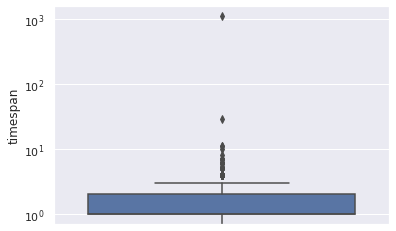

In [139]:
# Plotting
to_trending = temp.sample(1000).groupby('video_id').timespan.max() # CA
sns_ax = sns.boxplot(y = to_trending)
_ = sns_ax.set(yscale = "log")
plt.show()


Frequently occurring words in tags and description

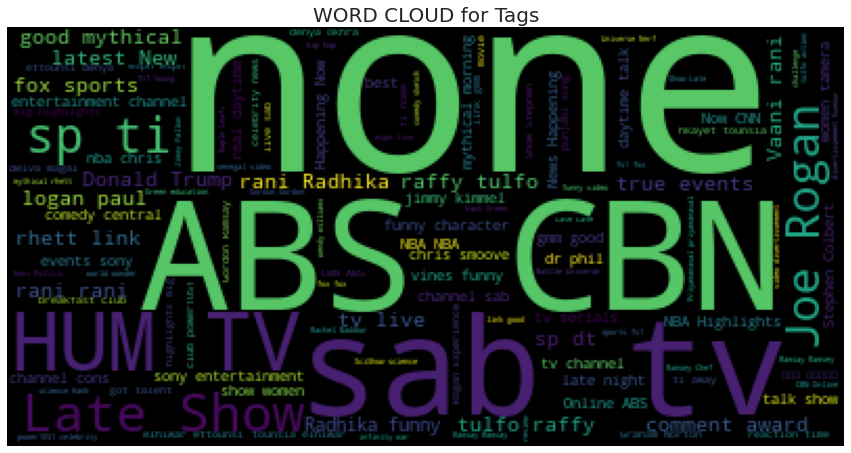

In [146]:
# For tags
import nltk
from wordcloud import WordCloud, STOPWORDS
# nltk.download('stopwords')
# STOPWORDS = stopwords.words('english')
plt.figure(figsize = (15, 15))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
  background_color = 'black',
  stopwords = stopwords,
  max_words = 1000,
  max_font_size = 120,
  random_state = 42
 ).generate(str(combined_df['tags']))
plt.imshow(wordcloud)
plt.title('WORD CLOUD for Tags', fontsize = 20)
plt.axis('off')
plt.show()


For desciption



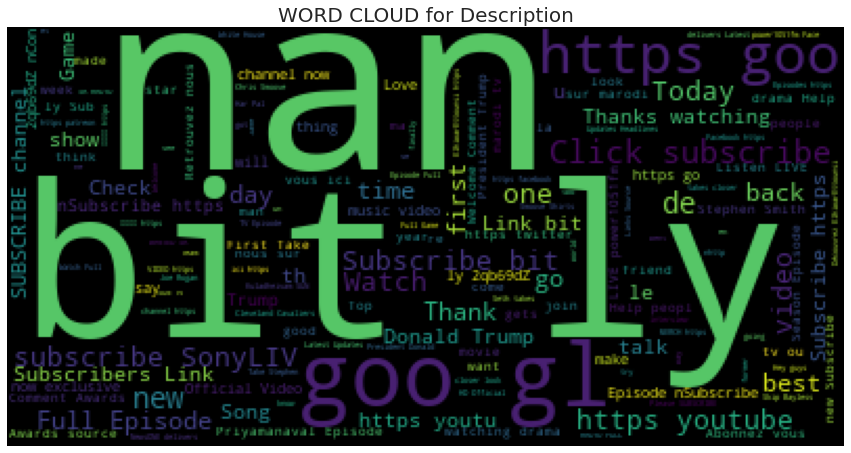

In [147]:
# For description
    
plt.figure(figsize = (15, 15))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
background_color = 'black',
stopwords = stopwords,
max_words = 1000,
max_font_size = 120,
random_state = 42
).generate(str(combined_df['description']))
plt.imshow(wordcloud)
plt.title('WORD CLOUD for Description', fontsize = 20)
plt.axis('off')
plt.show()

Correlation between views, likes, dislikes, and comments

In [148]:
col = ['views', 'likes', 'dislikes', 'comment_count']
corr = combined_df[col].corr()
corr

,views,likes,dislikes,comment_count
views,1.000000,0.809736,0.556490,0.648283
likes,0.809736,1.000000,0.455478,0.813525
dislikes,0.556490,0.455478,1.000000,0.593987
comment_count,0.648283,0.813525,0.593987,1.000000
